# PassiveAgressive Model

With instagram posts as train set, kaggle news as test set.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import requests
import json
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
import collections

In [2]:
# Load dataset 
df = pd.read_csv('main_df2.csv')


In [6]:
len(df)

8415

In [4]:
df.dropna(subset=['preprocessed_caption'], inplace=True)

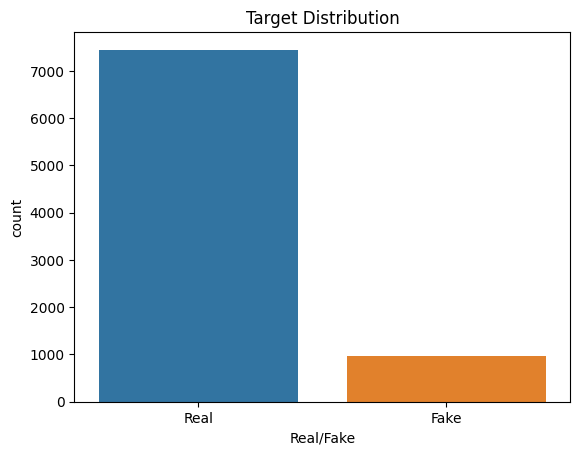

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='is_fake', data=df)
plt.title('Target Distribution')
plt.xlabel('Real/Fake')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()


In [6]:
df.groupby("is_fake").count()

,Unnamed: 0,level_0,index,Unnamed: 0.1,id,permalink,comments_count,like_count,media_type,media_url,timestamp,caption,actual_text,hashtags,is_english,english_caption,preprocessed_caption
is_fake,,,,,,,,,,,,,,,,,
0,7448,7448,7448,7448,7448,7448,7448,6991,7448,5916,7448,7448,7448,7281,7448,7448,7448
1,967,967,967,967,967,967,967,935,967,737,967,967,967,828,967,967,967


In [7]:
fake_preprocessed_caption = df[df['is_fake'] == 0]['preprocessed_caption'].tolist()
real_preprocessed_caption = df[df['is_fake'] == 1]['preprocessed_caption'].tolist()


Text(0.5, 1.0, 'Most common words in Title for Real News')

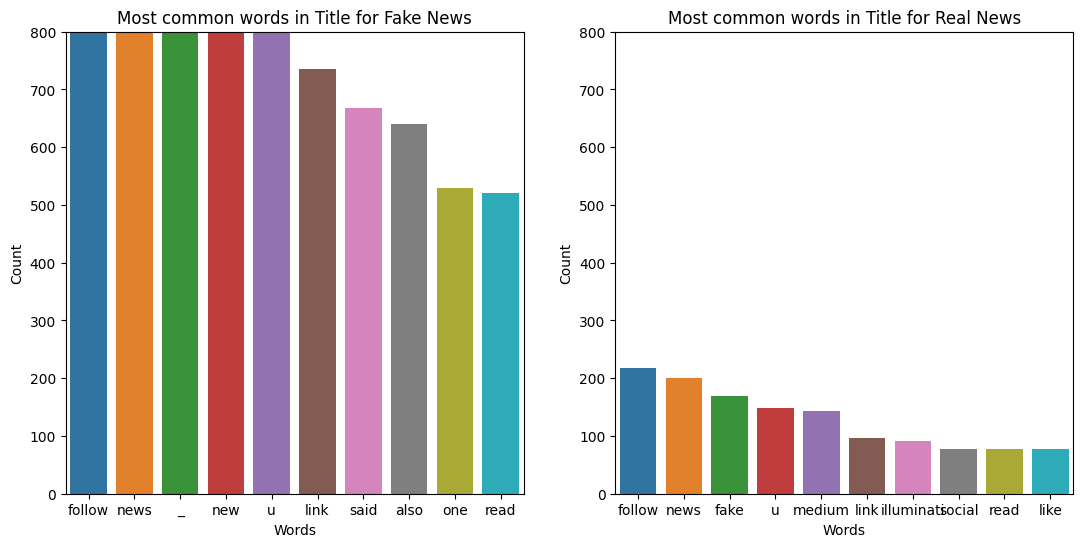

In [8]:
def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

# Convert the lists to string format
fake_preprocessed_caption = [str(caption) for caption in fake_preprocessed_caption]
real_preprocessed_caption = [str(caption) for caption in real_preprocessed_caption]

# Calculate word count
fake0_wrd = get_wrd_count(fake_preprocessed_caption)
real1_wrd = get_wrd_count(real_preprocessed_caption)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)

l0, h0, l1, h1 = [], [], [], []
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0])
ax[0].set_ylim(top=800)
ax[0].set_xticks(ticks=list(range(len(l0))))
ax[0].set_xticklabels(l0)
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Count')
ax[0].set_title("Most common words in Title for Fake News")

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1])
ax[1].set_ylim(top=800)
ax[1].set_xticks(ticks=list(range(len(l1))))
ax[1].set_xticklabels(l1)
ax[1].set_xlabel('Words')
ax[1].set_ylabel('Count')
ax[1].set_title("Most common words in Title for Real News")


In [9]:
#Drop very short captions 
df.drop(df[(df['preprocessed_caption'].str.len() < 45) & (df['is_fake']==0)].index, inplace=True)
df.drop(df[(df['preprocessed_caption'].str.len() < 45) & (df['is_fake']==1)].index, inplace=True)

In [10]:
# Sampling real posts to even up the number of fake and real
X_r=df[(df['preprocessed_caption'].str.len() >100) & (df['is_fake']==0)].sample(n=1000,random_state=42)[['preprocessed_caption','is_fake']]
X_f=df[(df['is_fake']==1)][['preprocessed_caption','is_fake']]
joined_df = X_r.append(X_f, ignore_index=False)
#Randomizing the entries
randomized_df = joined_df.sample(frac=1, random_state=42)
labels= randomized_df['is_fake']

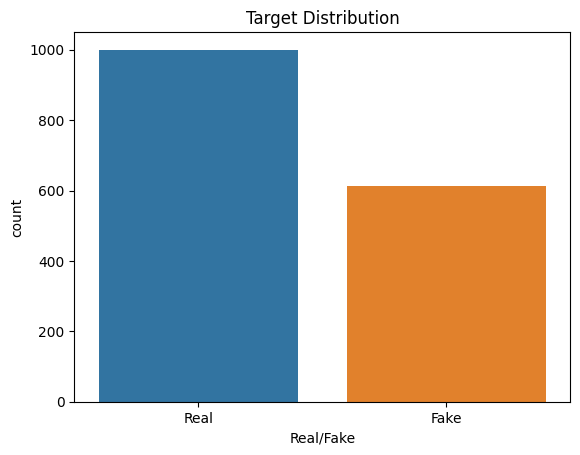

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='is_fake', data=joined_df)
plt.title('Target Distribution')
plt.xlabel('Real/Fake')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()


Test size of 15%

In [29]:
test_df = pd.read_csv('fakenews_train.csv')
test_df['text'].fillna('', inplace=True)

In [30]:
x_train, x_test, y_train, y_test = train_test_split( randomized_df['preprocessed_caption'] ,labels, test_size=0.0001, random_state=42)

In [31]:
x_test = test_df['text']
y_test = test_df['label']

In [32]:
#TF-IDF considers how often the word appears in the entire corpus and assigns a weight 
#to each word based on how important it is in the document.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)

In [33]:

tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

In [34]:
# Modified perceptron that avoids misclassifications
pac = PassiveAggressiveClassifier( max_iter = 50)
pac.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

In [35]:
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test,y_pred)
print( 'Model Accuracy :', round(score*100,2) )

Model Accuracy : 59.22


In [41]:
results_df= pd.DataFrame(y_test)
results_df['y_test']=""
results_df['y_test']=results_df['label']
results_df.drop(columns="label", inplace=True)
results_df['y_pred']=y_pred

results_df = results_df.merge(test_df, left_index=True, right_index=True, how='inner')


In [43]:
results_df.columns

Index(['y_test', 'y_pred', 'id', 'title', 'author', 'text', 'label'], dtype='object')

In [44]:
results_df[['y_test', 'y_pred', 'label',
       'id', 'title',  'author', 'text']]

,y_test,y_pred,label,id,title,author,text
0,1,0,1,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,0,0,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,1,1,1,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,1,0,1,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,1,0,1,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...
...,...,...,...,...,...,...,...
20795,0,1,0,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...
20796,0,0,0,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...
20797,0,0,0,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...
20798,1,0,1,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal..."


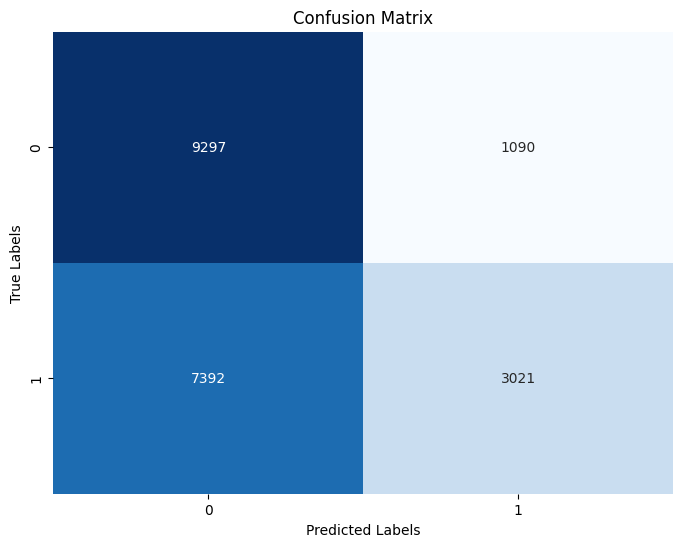

In [46]:
# Calculate the confusion matrix
cm = confusion_matrix(results_df['y_test'], results_df['y_pred'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Selecting true positive instances
true_positive_df = results_df[(results_df['y_test'] == 1) & (results_df['y_test'] == results_df['y_pred'])]



In [48]:
results_df[results_df['y_test']==results_df['y_pred']]

,y_test,y_pred,id,title,author,text,label
1,0,0,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,1,1,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
5,0,0,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,0,0,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,0,0,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
...,...,...,...,...,...,...,...
20790,0,0,20790,Nikki Haley Blasts U.N. Human Rights Office fo...,Adam Shaw,U. S Ambassador to the United Nations Nikki Ha...,0
20792,0,0,20792,"Jakarta Bombing Kills Three Police Officers, L...",John Hayward,Two suicide bombers attacked a bus station in ...,0
20793,1,1,20793,Idiot Who Destroyed Trump Hollywood Star Gets ...,Robert Rich,Share This \nAlthough the vandal who thought i...,1
20796,0,0,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4c8af7b1-f3b8-45ab-bbdc-6a32713107d1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>